In [1]:
from google.colab import files
uploaded = files.upload()
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader

# -------------------------
# 1. Load CSV Data
# -------------------------
df = pd.read_csv("deeponet_2d_advection_data1.csv")

# Trunk inputs (coords)
trunk_input = df[['r', 'theta', 't']].values.astype(np.float32)

# Branch inputs (initial condition vector, all b0,b1,... columns)
branch_cols = [c for c in df.columns if c.startswith("b")]
branch_input = df[branch_cols].values.astype(np.float32)

# Target output
u_true = df[['u_true']].values.astype(np.float32)

# -------------------------
# 2. Dataset + Dataloader
# -------------------------
class DeepONetDataset(Dataset):
    def __init__(self, branch, trunk, target):
        self.branch = torch.tensor(branch)
        self.trunk = torch.tensor(trunk)
        self.target = torch.tensor(target)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.branch[idx], self.trunk[idx], self.target[idx]

dataset = DeepONetDataset(branch_input, trunk_input, u_true)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# -------------------------
# 3. Define DeepONet
# -------------------------
class DeepONet(nn.Module):
    def __init__(self, branch_in, trunk_in, hidden=64, out_dim=1):
        super(DeepONet, self).__init__()
        # Branch net
        self.branch_net = nn.Sequential(
            nn.Linear(branch_in, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden)
        )
        # Trunk net
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_in, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden)
        )
        # Output projection
        self.output_layer = nn.Linear(hidden, out_dim)

    def forward(self, branch_input, trunk_input):
        b = self.branch_net(branch_input)
        t = self.trunk_net(trunk_input)
        # element-wise product then projection
        x = b * t
        return self.output_layer(x)

branch_in = branch_input.shape[1]
trunk_in = trunk_input.shape[1]
model = DeepONet(branch_in, trunk_in)

# -------------------------
# 4. Training
# -------------------------
#criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-3)

#epochs = 20
#for epoch in range(epochs):
 #   total_loss = 0
  #  for b, t, u in dataloader:
   #     optimizer.zero_grad()
    #    u_pred = model(b, t)
     #   loss = criterion(u_pred, u)
      #  loss.backward()
       # optimizer.step()
        #total_loss += loss.item()
    #print(f"Epoch {epoch+1}/{epochs}, Loss = {total_loss/len(dataloader):.6f}")

# -------------------------
# 5. Save trained model
# -------------------------
#torch.save(model.state_dict(), "deeponet_advection_trained.pth")
#print("✅ Training finished, model saved.")

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(10, 4))

# Initial condition (t=0)
p0 = axs[0].pcolormesh(Theta, R, U_t0, shading='auto', cmap='viridis')
axs[0].set_title(r"Initial Condition: $u(r,\theta,0)$", pad=25)
fig.colorbar(p0, ax=axs[0])

# Solution at t=1
p1 = axs[1].pcolormesh(Theta, R, U_t1, shading='auto', cmap='viridis')
axs[1].set_title(r"Predicted Output: $u(r,\theta,1)$", pad=25)
fig.colorbar(p1, ax=axs[1])

plt.tight_layout(pad=3.0)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'deeponet_2d_advection_data1.csv'

In [4]:
import numpy as np
import pandas as pd
from scipy.special import j1, jn_zeros

# -------------------------
# Grid parameters
# -------------------------
Nr, Ntheta, Nt = 20, 5, 10
r = np.linspace(0, 1, Nr)
theta = np.linspace(0, 2*np.pi, Ntheta)
t = np.linspace(0, 1.0, Nt)
R, Theta, T = np.meshgrid(r, theta, t, indexing='ij')

# -------------------------
# Physical parameters
# -------------------------
alpha = jn_zeros(1, 1)[0]   # first zero of J1
omega = 2 * np.pi           # angular velocity (you can change this)

# -------------------------
# Initial condition u(r,θ,0)
# -------------------------
U0 = 2 * np.cos(Theta[:, :, 0]) * j1(alpha * R[:, :, 0])

# -------------------------
# True rotating solution u(r,θ,t)
# -------------------------
U = 2 * np.cos(Theta - omega * T) * j1(alpha * R)

# Flatten data for saving
U_flat = U.flatten()
coords = np.stack([R.flatten(), Theta.flatten(), T.flatten()], axis=-1)

# -------------------------
# Build DataFrame
# -------------------------
data_dict = {
    'r': coords[:, 0],
    'theta': coords[:, 1],
    't': coords[:, 2],
    'u_true': U_flat
}

# Add branch inputs (same for all t): flattened initial condition values
branch_flat = U0.flatten()
for i, val in enumerate(branch_flat):
    data_dict[f'b{i}'] = val

df = pd.DataFrame(data_dict)

# -------------------------
# Save CSV
# -------------------------
df.to_csv('deeponet_2d_advection_data1.csv', index=False)
print("✅ CSV file generated with rotating solution: deeponet_2d_advection_data1.csv")

# Optional: quick preview
print(df.head())


✅ CSV file generated with rotating solution: deeponet_2d_advection_data1.csv
     r  theta         t  u_true   b0   b1   b2   b3   b4        b5  ...  \
0  0.0    0.0  0.000000     0.0  0.0  0.0 -0.0 -0.0  0.0  0.200645  ...   
1  0.0    0.0  0.111111     0.0  0.0  0.0 -0.0 -0.0  0.0  0.200645  ...   
2  0.0    0.0  0.222222     0.0  0.0  0.0 -0.0 -0.0  0.0  0.200645  ...   
3  0.0    0.0  0.333333    -0.0  0.0  0.0 -0.0 -0.0  0.0  0.200645  ...   
4  0.0    0.0  0.444444    -0.0  0.0  0.0 -0.0 -0.0  0.0  0.200645  ...   

        b90           b91       b92           b93       b94           b95  \
0  0.165831  1.015423e-17 -0.165831 -3.046269e-17  0.165831 -1.867169e-16   
1  0.165831  1.015423e-17 -0.165831 -3.046269e-17  0.165831 -1.867169e-16   
2  0.165831  1.015423e-17 -0.165831 -3.046269e-17  0.165831 -1.867169e-16   
3  0.165831  1.015423e-17 -0.165831 -3.046269e-17  0.165831 -1.867169e-16   
4  0.165831  1.015423e-17 -0.165831 -3.046269e-17  0.165831 -1.867169e-16   

         

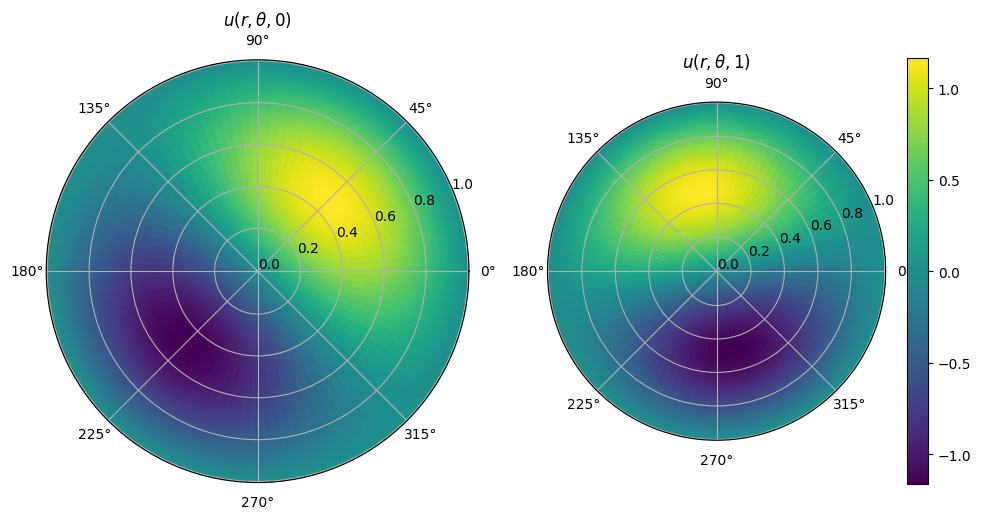

In [4]:
# ===============================================================
# Step 1. Imports
# ===============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import jn, jn_zeros
from google.colab import files

# ===============================================================
# Step 2. Define analytical rotating solution
# ===============================================================
# Parameters
n, m = 1, 1
alpha = jn_zeros(n, m)[-1]   # first zero of J1
omega = 1.0                  # angular velocity

# Shift parameter (positive → right / clockwise)
theta_shift = np.pi / 4  # 45 degrees shift

# Grid setup
Nr, Ntheta, Nt = 100, 100, 20
r = np.linspace(0, 1, Nr)
theta = np.linspace(0, 2*np.pi, Ntheta)
t = np.linspace(0, 1, Nt)

R, Theta, T = np.meshgrid(r, theta, t, indexing='ij')

# Analytical solution: rotating cosine pattern with right shift
u_true = 2 * np.cos(Theta - omega*T - theta_shift) * jn(1, alpha*R)

# ===============================================================
# Step 3. Save dataset (r, θ, t, u)
# ===============================================================
data = {
    'r': R.ravel(),
    'theta': Theta.ravel(),
    't': T.ravel(),
    'u_true': u_true.ravel()
}
df = pd.DataFrame(data)
df.to_csv("FBDeepONet_dataset.csv", index=False)
#files.download("FBDeepONet_dataset.csv")
#print("✅ Dataset generated and ready for download.")

# ===============================================================
# Step 4. Visualize true solution at t=0 and t=1
# ===============================================================
u_t0 = u_true[:, :, 0]
u_t1 = u_true[:, :, -1]

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(10, 5))

# --- Plot at t=0
p0 = axs[0].pcolormesh(theta, r, u_t0, shading='auto', cmap='viridis')
axs[0].set_title(r"$u(r,\theta,0)$",pad=25)

# --- Plot at t=1
p1 = axs[1].pcolormesh(theta, r, u_t1, shading='auto', cmap='viridis')
axs[1].set_title(r"$u(r,\theta,1)$",pad=25)

# Add colorbar that spans both plots
fig.colorbar(p1, ax=axs[1], orientation='vertical')

plt.tight_layout()
plt.show()
